In [ ]:
import wbdata
import pandas as pd
import numpy as np
import json
from openai import OpenAI
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import time
import warnings
import math
import re
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from ast import literal_eval  #Is used to safely evaluate a string that looks like a Python literal 
import logging
logging.getLogger('shelved_cache.persistent_cache').setLevel(logging.ERROR) #Libraries warnings
warnings.filterwarnings('ignore') #Python warnings

In [3]:
import tiktoken

# Use OpenAI tokenizer to calculate token lengths (optional, more accurate)
def estimate_token_count(text, model="gpt-3.5-turbo-instruct"):
    enc = tiktoken.encoding_for_model(model)
    return len(enc.encode(text))

In [76]:
base_prompt  = """
You are a data scientist tasked with selecting the most relevant development indicators to predict when a country will reach the GDP per capita level of developed countries.

Below is a list of available indicators retrieved from the World Bank. Each item consists of an indicator code and its corresponding name:

{chunked_indicators}

Your task:
- Select indicators that are strongly related to GDP growth, economic development, or structural transformation (e.g., education, infrastructure, industrialization, trade, institutions).
- Prioritize indicators that are leading indicators or have a causal influence on development.
- Ensure diversity across categories such as macroeconomy, infrastructure, education, health, technology, labor, and governance.
- Select only {number_of_indicators_per_chunk} indicators. Do not exceed this number.
- Dict_indicators must have only {number_of_indicators_per_chunk} keys
- Do not select any indicator related with CPIA

Output format:
- Return a valid Python dictionary where each key is the indicator code, and the value is a short, clean summary of the indicator's meaning.
- Clean each indicator name by removing any special characters, keeping only letters, spaces, and the '%' sign.
- Do not include code wrapping, markdown formatting, comments, or line breaks.
- Output only the dictionary in a single line, formatted like this:

dict_indicators = {{'CODE1': 'Abstract indicator name meaning 1','CODE2': 'Abstract indicator name meaning 2'}} """


In [77]:
available_indicators = wbdata.get_indicators(source=2)
# available_str = "\n".join([f"{i['id']}: {i['name']}" for i in available_indicators])
df_indicators = pd.DataFrame(available_indicators)[['id','name']]

enc = tiktoken.encoding_for_model("gpt-3.5-turbo-instruct")
df_indicators["token_count"] = df_indicators["name"].apply(lambda x: len(enc.encode(x)))

base_prompt_count = estimate_token_count(base_prompt)
model_max_tokens = 2500   # Model's maximum context length is 4097 tokens
max_prompt_tokens = model_max_tokens - base_prompt_count
chunk_index = []

for i in range(1,len(df_indicators)):
    if len(chunk_index) == 0:
        list_indicators = "\n".join((df_indicators["id"][0:i] + ": " + df_indicators["name"][0:i]).tolist())
        token_count = estimate_token_count(list_indicators)
    else:
        list_indicators = "\n".join((df_indicators["id"][current_index:i] + ": " + df_indicators["name"][current_index:i]).tolist())
        token_count = estimate_token_count(list_indicators)
    if token_count>max_prompt_tokens:
        current_index = i
        chunk_index.append(i)
        token_count = 0

list_indicators = (df_indicators["id"] + ": " + df_indicators["name"]).tolist()

chunks = [
    list_indicators[0:index] if i == 0 
    else list_indicators[chunk_index[i-1]:index]
    for i, index in enumerate(chunk_index)
]


In [78]:

# Load credentials
with open("credentials.json", "r") as file:
    credentials = json.load(file)

# Initialize the client
client = OpenAI(
    api_key=credentials["OPENAI_API_KEY"],
    base_url=credentials["OPENAI_API_BASE"]  # Only if using a proxy/alternative endpoint
)

# Decoding parameters
TEMPERATURE = 0.0
def query_openai(prompt):

    response = client.completions.create(
        model="gpt-3.5-turbo-instruct",
        prompt=prompt,
        temperature=TEMPERATURE,
        max_tokens=300  

    )
    time.sleep(5)  # rate limiting
    
    return response


In [ ]:
# max_indicators = 60
# n_chunks =  len(chunks)
# number_of_indicators_per_chunk = math.ceil(max_indicators/n_chunks)

# merged_dict = {}
# responses = []
# for idx, chunk in enumerate(chunks):
#     print(f"\n Running chunk {idx+1}/{n_chunks}...")
#     chunk_text = "\n".join(chunk)

#     prompt = base_prompt.format(
#         chunked_indicators=chunk_text,
#         number_of_indicators_per_chunk=number_of_indicators_per_chunk
#     )
    
#     success = False
#     retries = 3
#     for attempt in range(1, retries + 1):
#         try:
#             print(f"Attempt {attempt}...", end=" ")
#             response = query_openai(prompt)
#             responses.append(response)
#             # extract dict with regex
#             raw_text = response.choices[0].text.replace('\r', '').replace('\n', '').replace('\t', '').strip()+"'"+'}'
#             match = re.search(r"\{.*?\}", raw_text, re.DOTALL)
#             if not match:
#                 raise ValueError("No dictionary found in model response.")
            
#             chunk_dict = literal_eval(match.group(0))
#             merged_dict.update(chunk_dict)
#             print("Success.")
#             success = True
#             break
#         except Exception as e:

#             print(f"Error: {e}")
#             if attempt < retries:
#                 time.sleep(5)  # wait before retry
#             else:
#                 print(f"Failed chunk {idx+1} after {retries} attempts.")




 Running chunk 1/15...
Attempt 1... Success.

 Running chunk 2/15...
Attempt 1... Success.

 Running chunk 3/15...
Attempt 1... Success.

 Running chunk 4/15...
Attempt 1... Success.

 Running chunk 5/15...
Attempt 1... Success.

 Running chunk 6/15...
Attempt 1... Success.

 Running chunk 7/15...
Attempt 1... Success.

 Running chunk 8/15...
Attempt 1... Success.

 Running chunk 9/15...
Attempt 1... Success.

 Running chunk 10/15...
Attempt 1... Success.

 Running chunk 11/15...
Attempt 1... Success.

 Running chunk 12/15...
Attempt 1... Success.

 Running chunk 13/15...
Attempt 1... Success.

 Running chunk 14/15...
Attempt 1... Success.

 Running chunk 15/15...
Attempt 1... Success.


In [ ]:
# df_indicators = pd.DataFrame.from_dict(merged_dict , orient= 'index')
# df_indicators.to_csv('df_indicators.csv')

In [2]:
import pandas as pd
df_indicators = pd.read_csv('df_indicators.csv')

In [3]:
merged_dict = dict(zip(df_indicators.iloc[:, 0], df_indicators.iloc[:, 1]))
print(type(merged_dict))  # Should output <class 'dict'>


<class 'dict'>


In [84]:
america_countries = [
    'ARG', 'BLZ', 'BOL', 'BRA', 'CAN', 'CHL', 'COL', 
    'CRI', 'ECU', 'SLV', 'GTM', 'GUY', 'HND', 'MEX', 
    'NIC', 'PAN', 'PRY', 'PER', 'SUR', 'USA', 'URY'
]

# Adding target variable
merged_dict.update({'NY.GDP.PCAP.CD':'GDP per capita (current US$)'})

df = wbdata.get_dataframe(merged_dict, country=america_countries,date=("2000", "2025"))
df.reset_index(inplace = True)
# df.dropna(inplace=True)


In [85]:
def mull_heat_map(df, column_to_group):    
    # Calculate null rate by group (e.g., country or date)
    null_rates = df.groupby(column_to_group).apply(lambda x: x.isnull().mean())
    null_rates = null_rates.T  # Transpose for better visualization

    # Create heatmap
    plt.figure(figsize=(20 ,20))
    sns.heatmap(
        null_rates,
        cmap='YlOrRd',
        annot=True,
        fmt='.1%',
        linewidths=.5,
        cbar_kws={'label': 'Null Rate'}
    )

    # Titles and axis labels with bigger fonts
    plt.title('Null Rate by '+column_to_group, fontsize=12)
    plt.ylabel('Variable', fontsize=12)

    # Axis tick labels with bigger fonts
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.yticks(fontsize=12)

    plt.tight_layout()
    plt.show()

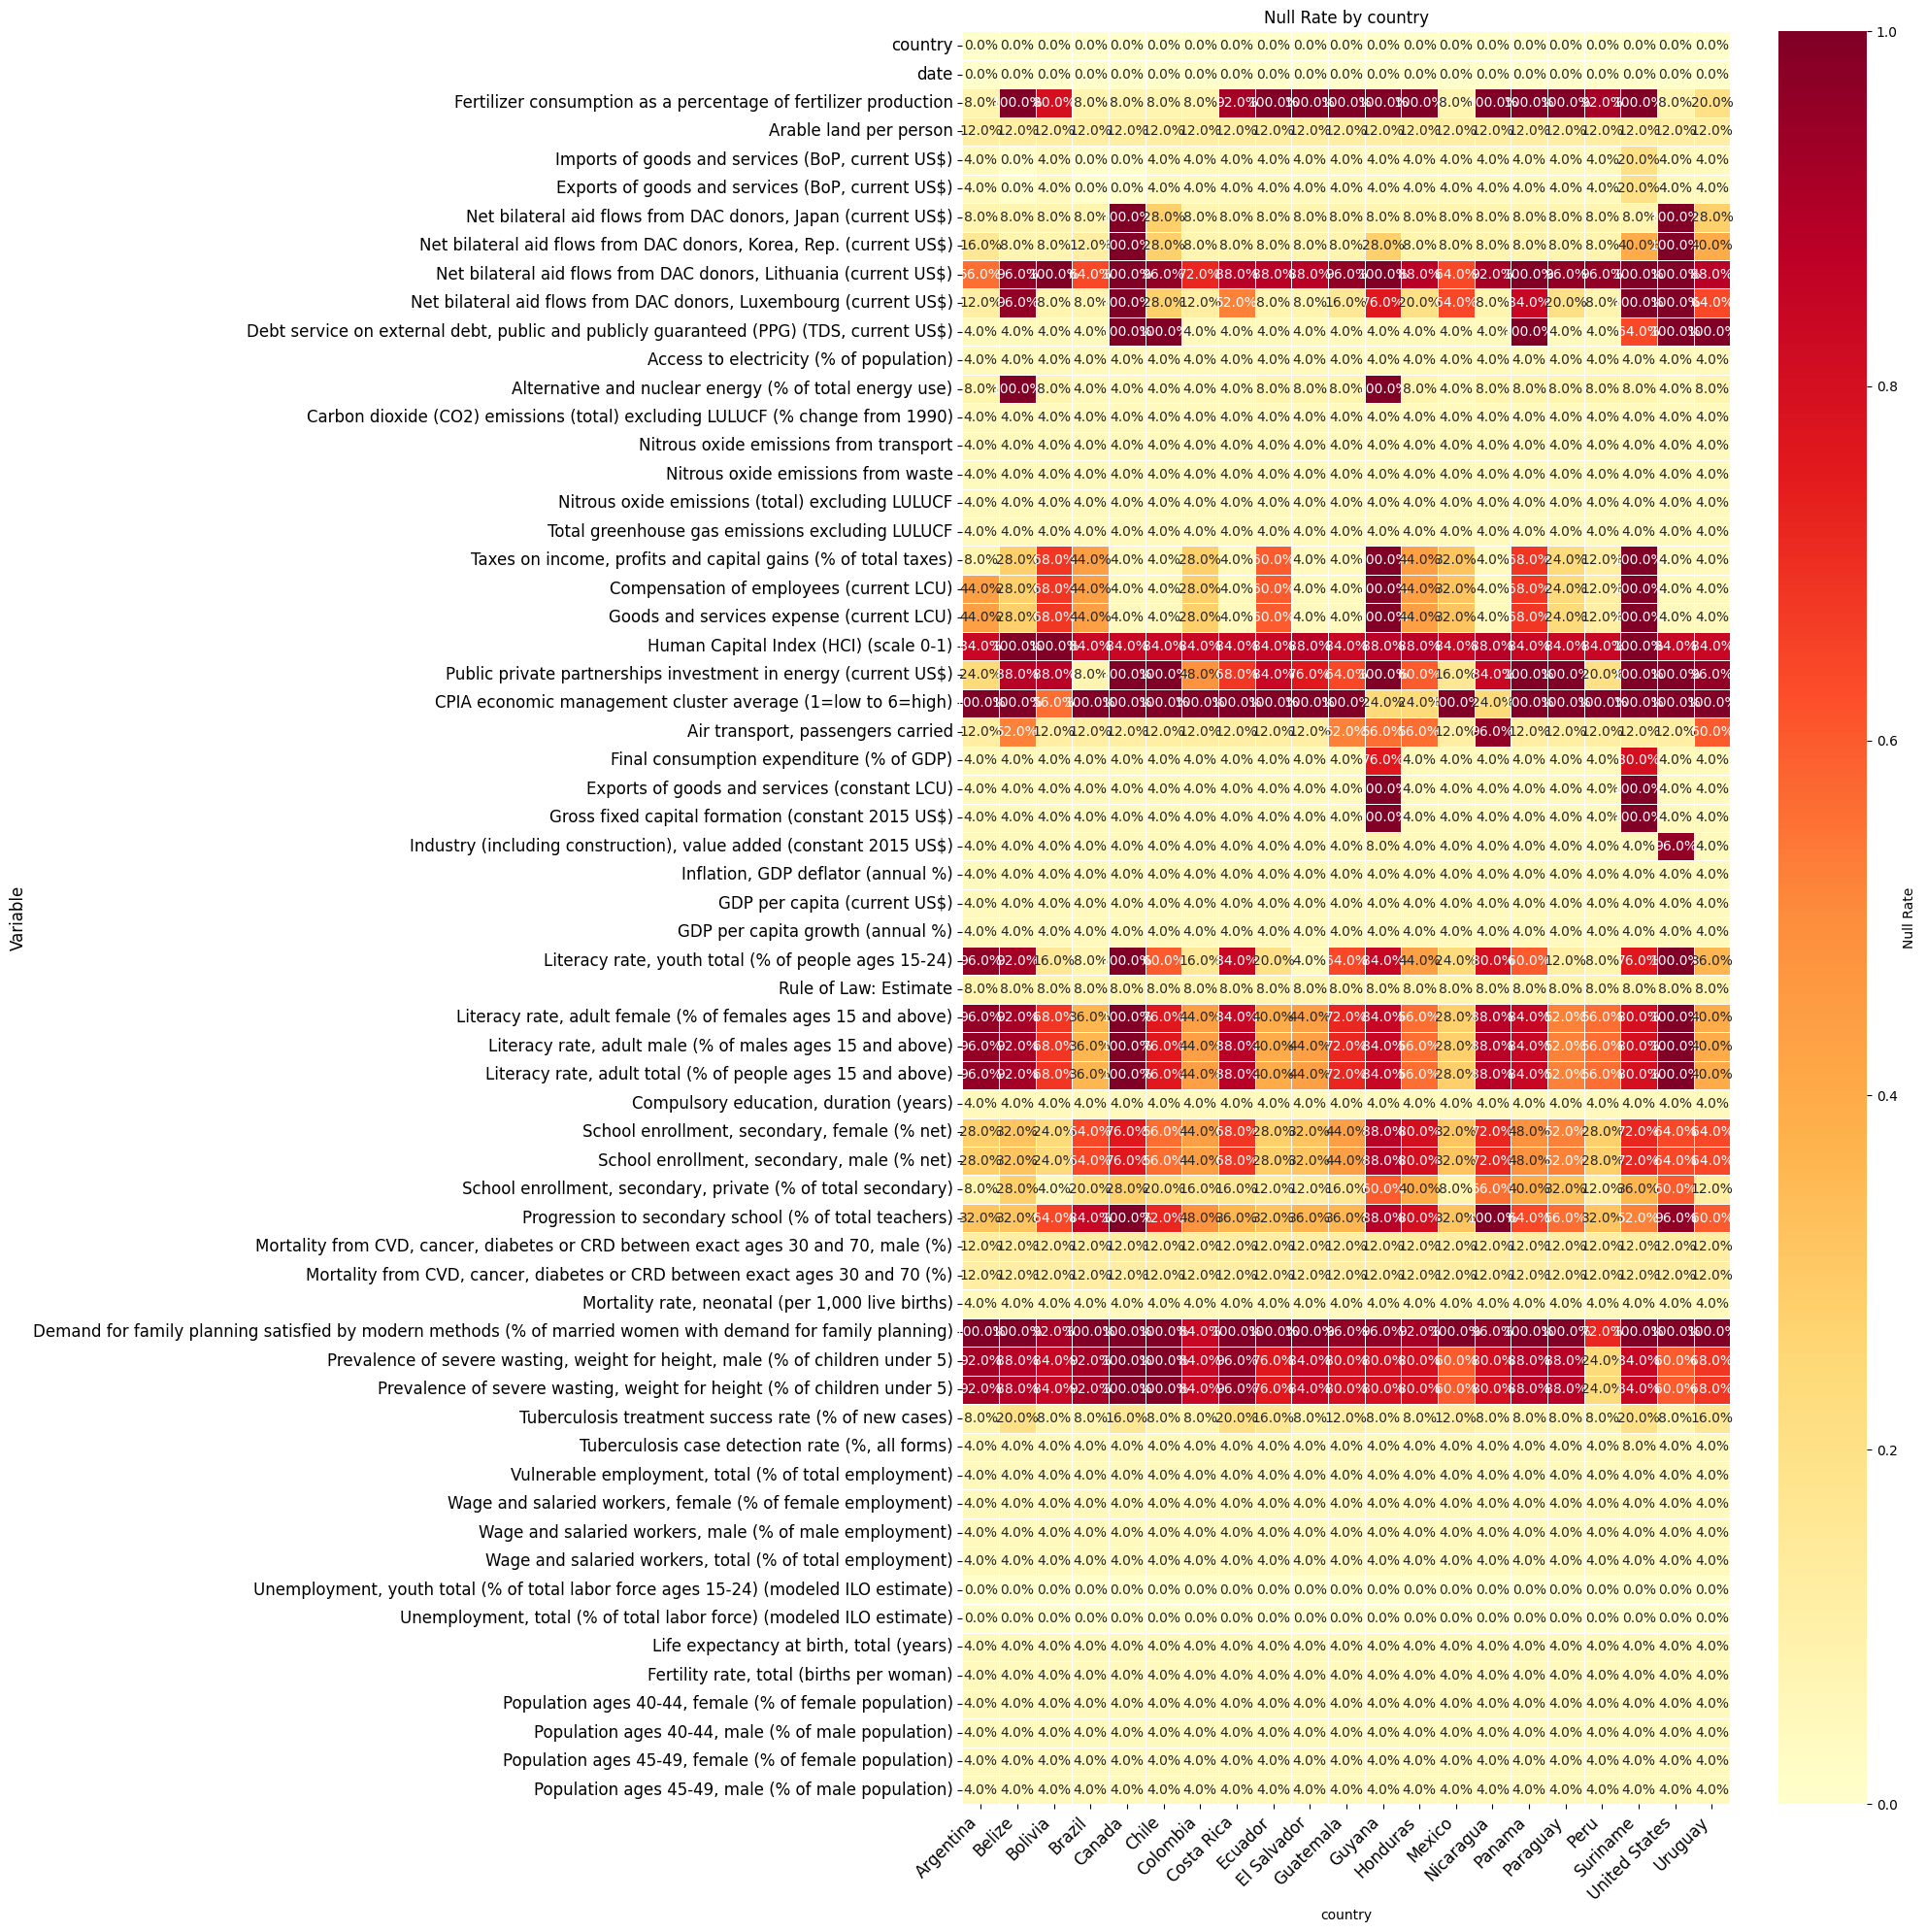

In [86]:
mull_heat_map(df,'country')

It is possible to see that the some indicators are not good, since most of its values are null

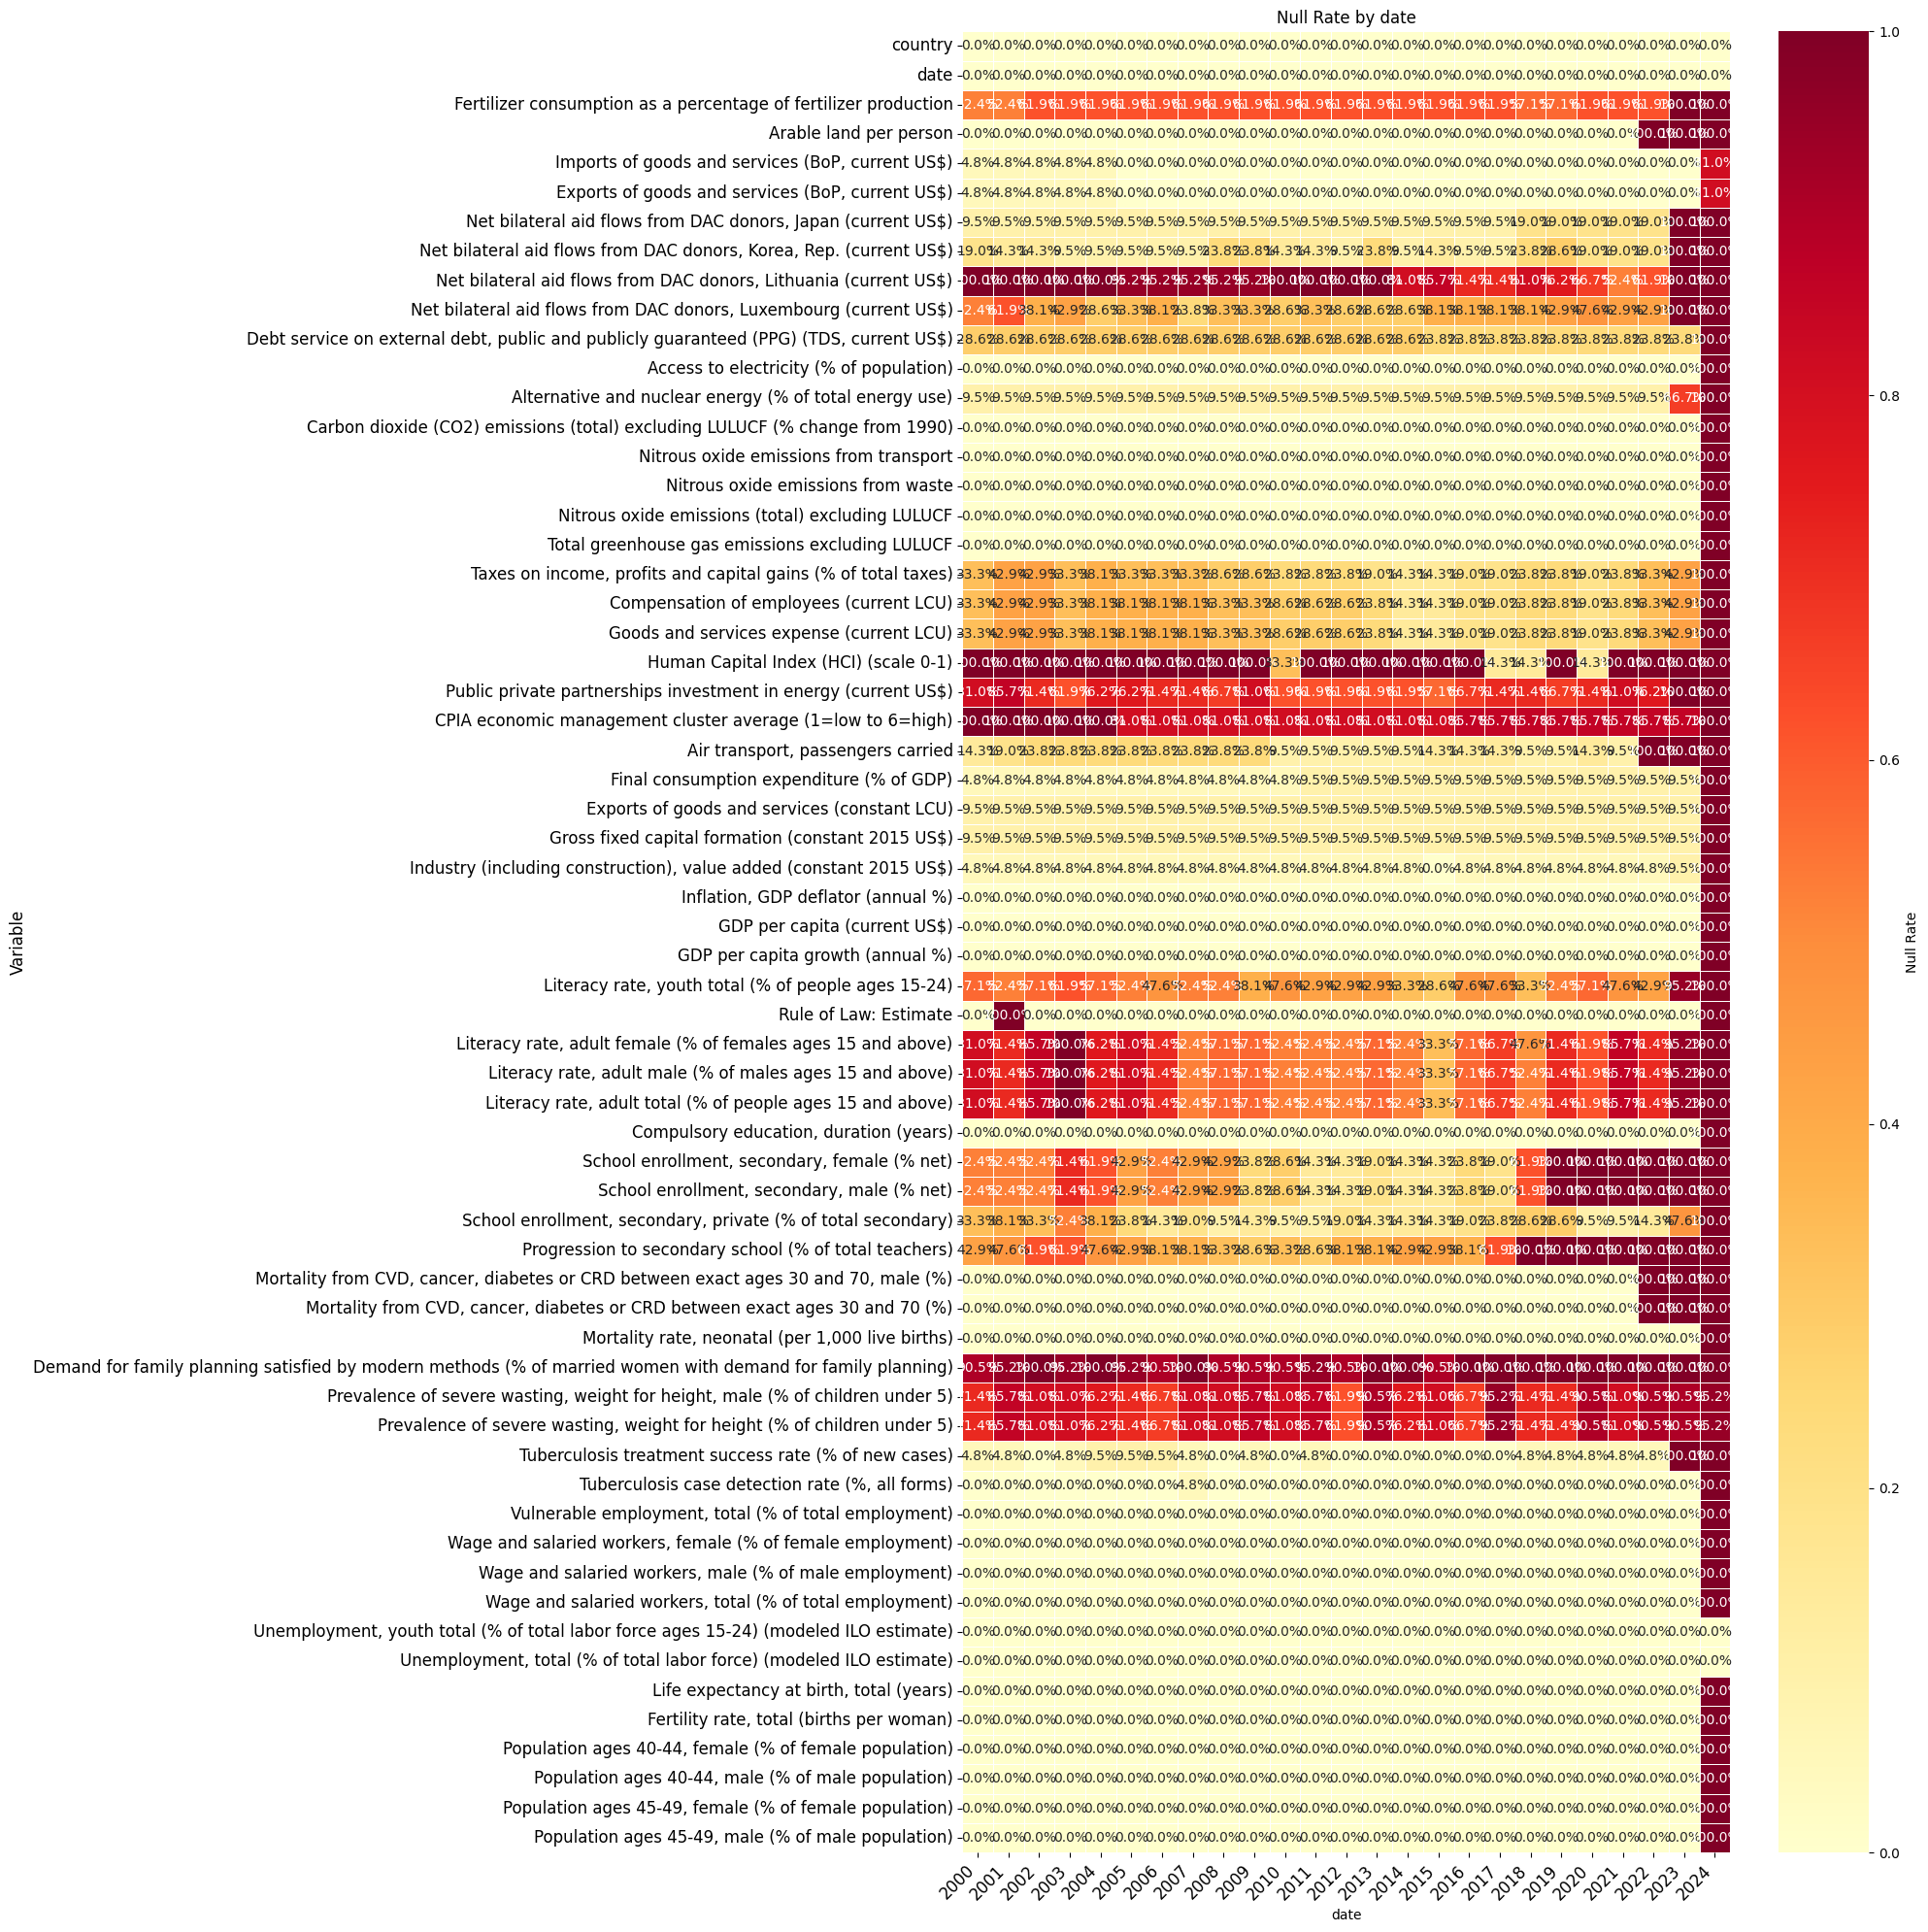

In [87]:
mull_heat_map(df,'date')

For this heat maps, we can see that the international migran stock indicator is not a good  indicator for us, since in many years we dont have any values in it, so we need to change that, furthermore we can remove that 2024 year from our data ser, for the same reason. 

In [88]:
threshold = 0.4  # % of missingness

df = df[df.date < '2024-01-01'] # to remove 2024 from the data set

null_rates_country = df.groupby(['country']).apply(lambda x: x.isnull().mean()).drop(columns = ['country'] ).reset_index()

columns_not_to_keep = []

for country in null_rates_country['country'].unique():
    country_data = null_rates_country[null_rates_country['country'] == country]
    
    for column in null_rates_country.columns[2:]:  # Skip 'country' and 'date'
        null_rate = country_data[column].values[0]  # Get the actual value (assumed to be a float)
        
        if null_rate > threshold:
            if column not in columns_not_to_keep:
                columns_not_to_keep.append(column)


In [89]:
columns_to_keep = [col for col in df.columns if col not in columns_not_to_keep]

print(f'Columns that have been dropped {columns_not_to_keep}')
print(f'Quantity of indicators dropped {len(columns_not_to_keep)} \nQuantity of keeped indicators {len(columns_to_keep)}')
df_filtered = df[columns_to_keep]

Columns that have been dropped ['Net bilateral aid flows from DAC donors, Lithuania (current US$)', 'Compensation of employees (current LCU)', 'Goods and services expense (current LCU)', 'Human Capital Index (HCI) (scale 0-1)', 'CPIA economic management cluster average (1=low to 6=high)', 'Literacy rate, youth total (% of people ages 15-24)', 'Literacy rate, adult female (% of females ages 15 and above)', 'Literacy rate, adult male (% of males ages 15 and above)', 'Literacy rate, adult total (% of people ages 15 and above)', 'Demand for family planning satisfied by modern methods (% of married women with demand for family planning)', 'Prevalence of severe wasting, weight for height, male (% of children under 5)', 'Prevalence of severe wasting, weight for height (% of children under 5)', 'Fertilizer consumption as a percentage of fertilizer production', 'Net bilateral aid flows from DAC donors, Luxembourg (current US$)', 'Alternative and nuclear energy (% of total energy use)', 'Public 

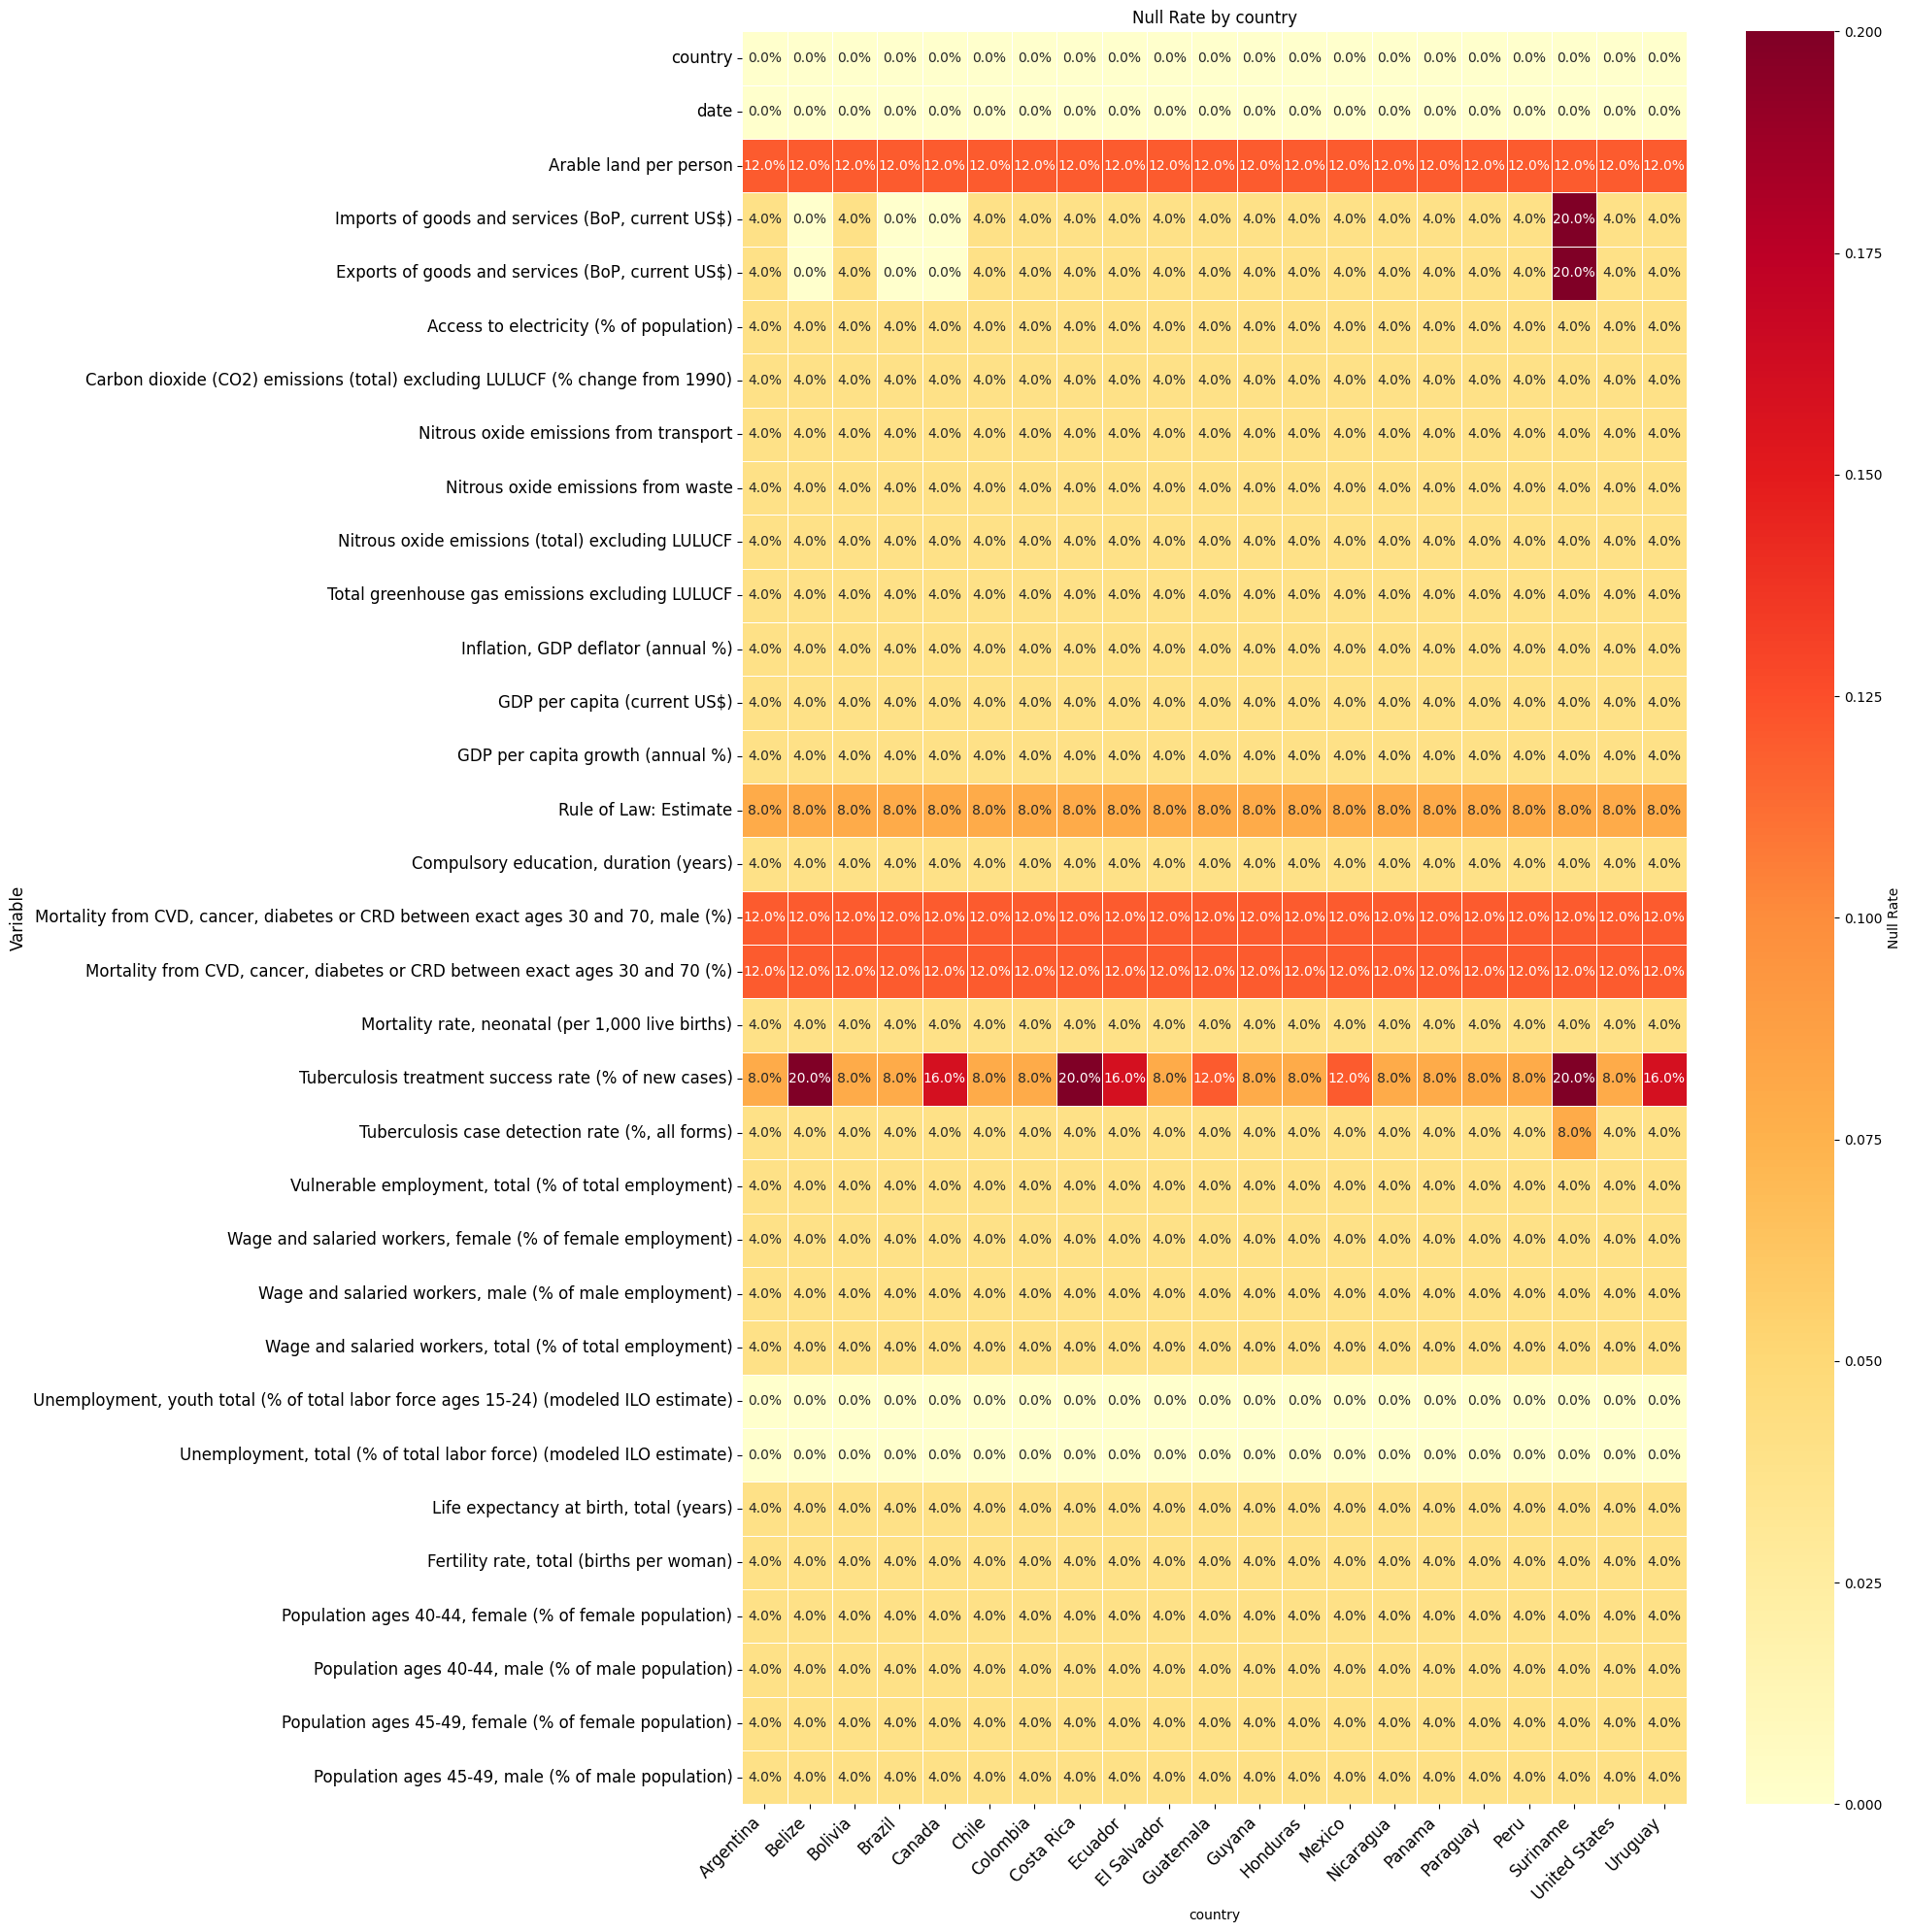

In [90]:
mull_heat_map(df_filtered,'country')

In [91]:
def imput_indicators_lr(df, country_col='country', year_col='date'):
    """
    Imputation using Lr
    
    Assumes:
    1. All indicator columns are numeric
    2. Year column is numeric
    3. Each country-indicator combo has ≥2 data points
    """
    df[year_col] = pd.to_numeric(df[year_col], errors='coerce')
    # Get indicator columns (exclude metadata)
    indicators = [col for col in df.columns 
                 if col not in {country_col, year_col}]
    
    # Single-pass imputation
    def impute_group(group):
        for col in indicators:
            # Get known values
            known = group[group[col].notna()]
            X = known[[year_col]]
            y = known[col]
            
            # Train and predict (no length checks needed)
            model = LinearRegression().fit(X, y)
            missing = group[col].isna()
            if missing.any():
                group.loc[missing, col] = model.predict(group.loc[missing, [year_col]])
        return group
    
    return df.groupby(country_col, group_keys=False).apply(impute_group)

In [103]:
df_filtered_imputed = imput_indicators_lr(df_filtered)


In [93]:
df_filtered_imputed.head()

,country,date,Arable land per person,"Imports of goods and services (BoP, current US$)","Exports of goods and services (BoP, current US$)",Access to electricity (% of population),Carbon dioxide (CO2) emissions (total) excluding LULUCF (% change from 1990),Nitrous oxide emissions from transport,Nitrous oxide emissions from waste,Nitrous oxide emissions (total) excluding LULUCF,...,"Wage and salaried workers, male (% of male employment)","Wage and salaried workers, total (% of total employment)","Unemployment, youth total (% of total labor force ages 15-24) (modeled ILO estimate)","Unemployment, total (% of total labor force) (modeled ILO estimate)","Life expectancy at birth, total (years)","Fertility rate, total (births per woman)","Population ages 40-44, female (% of female population)","Population ages 40-44, male (% of male population)","Population ages 45-49, female (% of female population)","Population ages 45-49, male (% of male population)"
0,Argentina,2000,0.742732,3.306880e+10,3.123692e+10,95.7,36.505516,0.6255,0.6108,5.636293,...,69.578068,72.379932,32.348,15.000,73.910,2.591,5.909290,6.048938,5.571662,5.621584
1,Argentina,2001,0.737439,2.759494e+10,3.111675e+10,95.5,31.101154,0.5851,0.6177,7.687405,...,68.745768,71.811744,37.036,17.320,74.154,2.531,5.886881,6.029053,5.569648,5.627375
2,Argentina,2002,0.732645,1.333722e+10,2.905450e+10,96.1,23.822709,0.5354,0.5992,10.627321,...,67.105497,71.663490,41.378,19.590,74.312,2.493,5.866275,6.011753,5.564064,5.628376
3,Argentina,2003,0.776285,1.872451e+10,3.433601e+10,96.3,34.991057,0.5357,0.5847,18.590130,...,70.238937,73.672292,32.933,15.360,74.307,2.451,5.857098,6.005709,5.550029,5.619298
4,Argentina,2004,0.819107,2.782364e+10,3.975725e+10,96.5,49.452427,0.6275,0.6041,23.605437,...,71.257087,74.383056,29.544,13.522,74.871,2.430,5.843036,5.991812,5.536989,5.610389


In [ ]:
df = df_filtered_imputed.copy()

# 1. Filter to the most recent year
target_year = df['date'].max()
df_latest = df[df['date'] == target_year].copy()

# 2. Select all numeric features (excluding 'country' and 'date') for PCA
features = [col for col in df_latest.columns if col not in ['country', 'date']]
X = df_latest[features].values

# 3. Apply StandardScaler to normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # This centers and scales the data

# 4. Perform PCA on the scaled data
pca = PCA()
X_pca = pca.fit_transform(X_scaled)  

# Explained variance
print("Explained variance per component:")
print(pca.explained_variance_ratio_)

Explained variance per component:
[3.53776506e-01 1.66722140e-01 1.38469301e-01 7.36067555e-02
 6.44093863e-02 4.25437007e-02 4.09510484e-02 3.17804612e-02
 2.47154768e-02 1.69453156e-02 1.36172422e-02 9.88653372e-03
 8.19009577e-03 5.15361136e-03 4.18906652e-03 1.84709962e-03
 1.50974328e-03 9.13032653e-04 5.31010703e-04 2.42472448e-04
 2.86242215e-33]


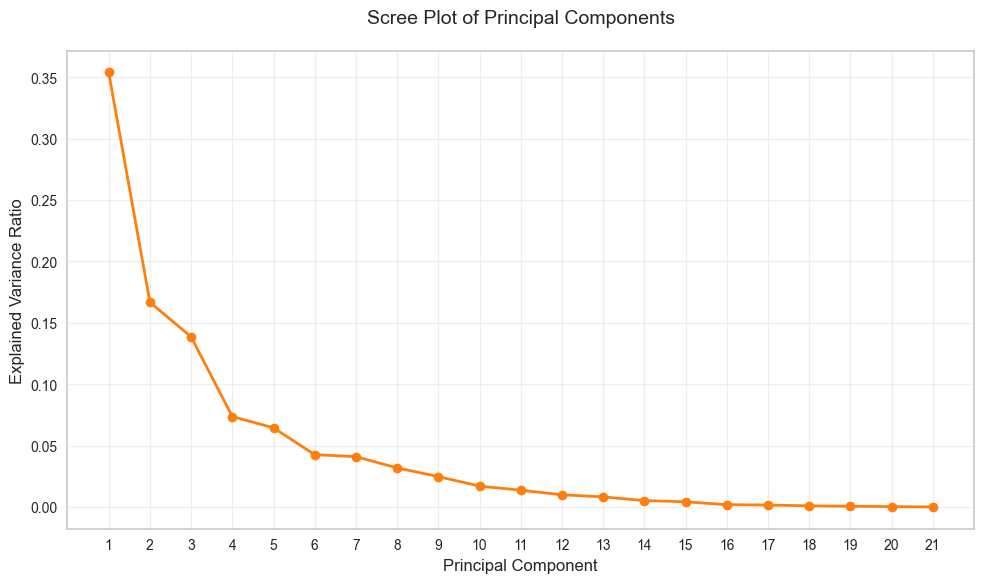

In [165]:
# Visualize the scree plot
plt.figure(figsize=(10, 6))
colors = plt.get_cmap('tab10')
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1),
         pca.explained_variance_ratio_, 
         'o-', 
         linewidth=2, 
         color=colors(1))  # Use first color from tab10 palette
plt.title('Scree Plot of Principal Components', fontsize=14, pad=20)
plt.xlabel('Principal Component', fontsize=12)
plt.ylabel('Explained Variance Ratio', fontsize=12)
plt.xticks(range(1, len(pca.explained_variance_ratio_) + 1))
plt.grid(True, alpha=0.3)
plt.tight_layout() 
plt.show()

In [152]:

# 4. Determine number of components to explain 90% variance
explained = pca.explained_variance_ratio_.cumsum()
n_selected = (explained >= 0.9).argmax()+1
print(f"Selecting top {n_selected} PCA components explaining {explained[n_selected-1]:.2%} variance.")
X_selected = X_pca[:, :n_selected]


Selecting top 8 PCA components explaining 91.23% variance.


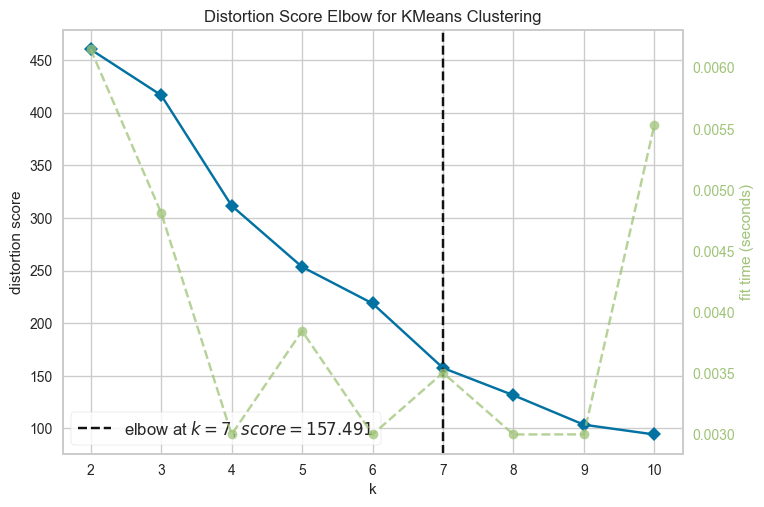

Best value using inertia 7


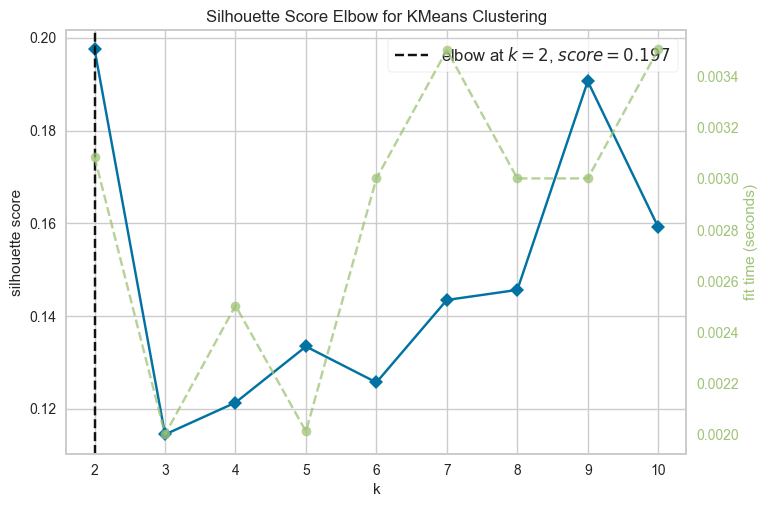

Best value using Silhouette 2


In [153]:
from yellowbrick.cluster import KElbowVisualizer

# Inertia (Elbow) Measures compactness (how close points are within clusters). Always decreases as K increases.
visualizer_inertia = KElbowVisualizer(KMeans(random_state=42), k=(2,11), metric='distortion')
visualizer_inertia.fit(X_selected)
visualizer_inertia.show()
print(f'Best value using inertia {visualizer_inertia.elbow_value_}')

# Silhouette - Silhouette measures quality of separation
visualizer_silhouette = KElbowVisualizer(KMeans(random_state=42), k=(2,11), metric='silhouette')
visualizer_silhouette.fit(X_selected)
visualizer_silhouette.show()
print(f'Best value using Silhouette {visualizer_silhouette.elbow_value_}')



I chose the Silhouette Score over the Elbow Method because it measures both cluster cohesion and separation, providing a clearer indication of cluster quality.
While the Elbow Method suggested 7 clusters based on inertia, the Silhouette Score indicated that 2 clusters were better separated and more meaningful.
To prioritize interpretability and stronger cluster distinction, I selected the number of clusters based on the Silhouette Score.

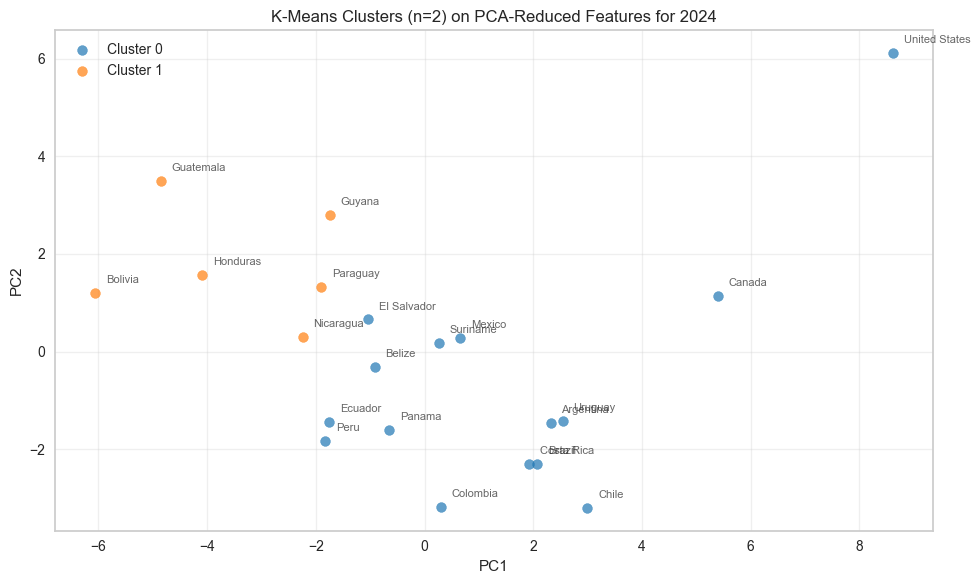

In [164]:

# 5. Apply K-Means clustering on the selected principal components
n_clusters = visualizer_silhouette.elbow_value_ # adjust as needed
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(X_selected)
df_latest['cluster'] = cluster_labels

# 6. Visualize clusters in the space of the first two principal components
plt.figure(figsize=(10, 6))
colors = plt.get_cmap('tab10')
for label in range(n_clusters):
    mask = cluster_labels == label
    plt.scatter(
        X_pca[mask, 0],
        X_pca[mask, 1],
        s=50,
        alpha=0.7,
        color=colors(label),
        label=f'Cluster {label}'
    )
offset = 0.2
for i in range(X_pca.shape[0]):
    plt.text(
        X_pca[i, 0]+offset, X_pca[i, 1]+offset, 
        df_latest['country'].iloc[i],  
        fontsize=8,
        alpha=0.7
    )


plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title(f'K-Means Clusters (n={n_clusters}) on PCA-Reduced Features for {target_year}')
plt.legend(loc='best')
plt.tight_layout()
plt.grid(True, alpha=0.3)
plt.show()


The United States is far from all other countries, even within Cluster 0, followed by Canada. This indicates that these countries have very distinct features compared to the others. This fact suggests that the United States and Canada has stronger indicators relative to other countries as expected.

Cluster 0 appears to represent higher-performing or more developed nations, while Cluster 1 groups less developed or similarly smaller economies closer together.

Since we used a small number of clusters, it is expected that our clustering results in good separation between clusters and interpretability.